In [46]:
# load up relavent libraries
library(ggplot2)
library(dplyr)
library(biomaRt)
library(Gviz)
library(cowplot)
library(ggrepel)
library(stringr)
theme_set(theme_classic() + theme(text = element_text(size=20, family = "sans")))
options(StringsAsFactors=FALSE)


# G2G Manhattan

In [2]:
# read in gwas and eQTL summary stats
gwas <- read.table("../data/MHCimp.97.assoc.txt.gz", h=T)
eQTL <- read.table("../data/GTEx_v8_lung_eQTL_summary_stats.txt.gz",h=T)

In [11]:
gwas$eQTLpval <- eQTL[match(gwas$id,eQTL$id),]$pvalue # check position and allele consistency
gwas$eQTLbeta <- eQTL[match(gwas$id,eQTL$id),]$beta # check position and allele consistency

gwas$eQTLvariant <- eQTL[match(gwas$id,eQTL$id),]$variant

df <- gwas %>% na.omit() %>%
    mutate(ps = str_split(id, ":", simplify = TRUE)[, 2]) %>%
    mutate(rsid = str_split(rs, ":", simplify = TRUE)[, 1])

r2 <- read.table("../data/rs3130660_r2.ld.gz",h=T) #TB g2g
df$r2 <- r2[match(df$rsid,r2$SNP_B),]$R2
df$r2 <- ifelse(is.na(df$r2),0,df$r2)
bins <- c(-Inf,0.2,0.4,0.6,0.8,1)


In [15]:

window <- 700000
pos <- 30706361
minpos <- pos - window
maxpos <- pos + window

dim(df)
topsnp <- "rs3130660:6:30706361"
df %>% filter(rs == topsnp)

r2col <- c("#fef0d9","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds


[1] 14967    12

rs,af,beta,se,p_lrt,id,eQTLpval,eQTLbeta,eQTLvariant,ps,rsid,r2
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<dbl>
rs3130660:6:30706361,0.011,0.3262018,0.04120181,9.236314e-15,6:30738584,2.2168e-16,0.28213,chr6_30738584_T_A,30738584,rs3130660,1


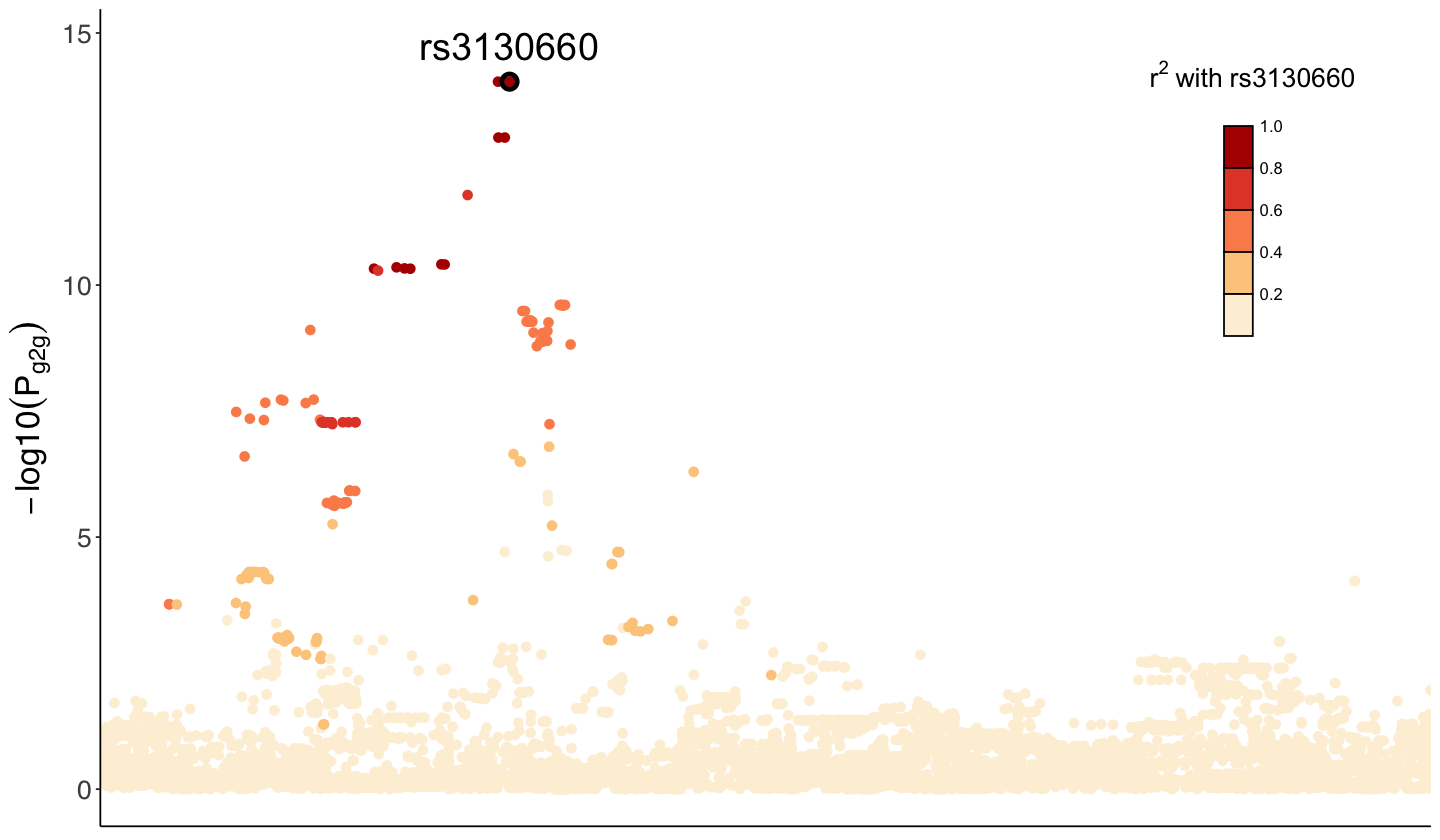

In [29]:

pGWAS <- ggplot(data=df %>% filter(ps >= minpos & ps <=maxpos ),aes(stroke=0)) +
    geom_point(aes(x=ps,y=-log10(p_lrt),color=cut(r2,bins)),size=3) + # GWAS plot
    ylab(bquote(-log10(P[g2g]))) + xlab("") 

options(repr.plot.width = 12, repr.plot.height = 7)

#pGWAS <- pGWAS + scale_x_continuous(expand = c(0, 0)) 
pGWAS <- pGWAS + geom_text(data=df %>% filter(rs==topsnp),aes(x=ps,y=-log10(p_lrt)*1.05), 
                              label="rs3130660",size=8,col="black")

# pGWAS <- pGWAS + geom_point(data=df %>% filter(rs==topsnp),aes(x=hg38,y=-log10(p_lrt)),
#                 colour = "red", size=1,stroke = 2)


pGWAS <- pGWAS + geom_point(data=df %>% filter(rs==topsnp),aes(x=ps,y=-log10(p_lrt)),
                shape = 1, colour = "black", size=3,stroke = 2)

pGWAS  <- pGWAS +  scale_color_manual(bquote("LD" ~ r^2 ~ "with" ~{.("rs3130660")}), 
                          values = rev(c("(-Inf,0.2]" = r2col[1],
                                    "(0.2,0.4]"= r2col[2],
                                    "(0.4,0.6]" = r2col[3],
                                    "(0.6,0.8]" = r2col[4],
                                    "(0.8,1]" = r2col[5])),
                        label=rev(c("0-0.2","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1")),
                                     guide="none")

legend_box = data.frame(x = 0.85, y = seq(0.8, 0.6, -0.05))

pGWAS <- pGWAS +   xlab("") + theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank())
pGWAS <- ggdraw(pGWAS) +
            geom_rect(data = legend_box,
                      aes(xmin = x, xmax = x + 0.02, ymin = y, ymax = y + 0.05),
                      color = "black",
                      fill = rev(r2col)) +
            draw_label("1.0", x = legend_box$x[1] + 0.02, y = 0.85, hjust = -0.3, size = 10) +
            draw_label("0.8", x = legend_box$x[1] + 0.02, y = legend_box$y[1], hjust = -0.3, size = 10) +
            draw_label("0.6", x = legend_box$x[2] + 0.02, y = legend_box$y[2], hjust = -0.3, size = 10) +
            draw_label("0.4", x = legend_box$x[3] + 0.02, y = legend_box$y[3], hjust = -0.3, size = 10) +
            draw_label("0.2", x = legend_box$x[4] + 0.02, y = legend_box$y[4], hjust = -0.3, size = 10) +
            draw_label(parse(text = "r^2~with~rs3130660"), x = legend_box$x[1] + 0.02, y = legend_box$y[1], vjust = -3, size = 16)

options(repr.plot.width = 12, repr.plot.height = 7)

pGWAS
    

# *FLOT1* eQTL Manhattan (GTEx lung)

In [31]:
# Load r2 info from 1000G EUR inds
rs3132610r2 <- read.table("../data/rs3132610_r2.ld.gz",h=T)
rs3132610r2$id <- str_replace(rs3132610r2$Coord,"chr","")
col1 <- c("#fef0d9","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds
col1 <- c("gray90","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds

rs3132610r2$color = as.character(cut(rs3132610r2$R2,breaks=c(0,0.2,0.4,0.6,0.8,1), 
                                     labels=(col1), include.lowest=TRUE))


rs9461629r2 <- read.table("../data/rs9461629_r2.ld.gz",h=T)
rs9461629r2$id <- str_replace(rs9461629r2$Coord,"chr","")
#col2<- c("#eff3ff","#bdd7e7","#6baed6","#3182bd","#08519c") #blues
col2<- c("gray91","#bdd7e7","#6baed6","#3182bd","#08519c") #blues
rs9461629r2$color = as.character(cut(rs9461629r2$R2,breaks=c(0,0.2,0.4,0.6,0.8,1), 
                                     labels=(col2), include.lowest=TRUE))



In [32]:
eQTL$rs3132610r2 <- 0
eQTL$rs3132610r2 <- rs3132610r2[match(eQTL$id,rs3132610r2$id),]$R2
eQTL$rs3132610r2 <- ifelse(is.na(eQTL$rs3132610r2),0,eQTL$rs3132610r2)
eQTL$col1 <- rs3132610r2[match(eQTL$id,rs3132610r2$id),]$color

eQTL$rs9461629r2 <- 0
eQTL$rs9461629r2 <- rs9461629r2[match(eQTL$id,rs9461629r2$id),]$R2
eQTL$rs9461629r2 <- ifelse(is.na(eQTL$rs9461629r2),0,eQTL$rs9461629r2)
eQTL$col2 <- rs9461629r2[match(eQTL$id,rs9461629r2$id),]$color

eQTL$col <- ifelse(eQTL$rs3132610r2>eQTL$rs9461629r2,eQTL$col1,eQTL$col2)


In [36]:
options(repr.plot.width = 12, repr.plot.height = 7)

eQTL$color <- factor(eQTL$col,levels=c((col1),rev(col2)))

peQTL <- ggplot(data=eQTL %>% filter(position >= minpos & position <=maxpos & is.na(color)),aes(stroke=0)) +
    geom_point(aes(x=position,y=-log10(pvalue)),col="gray90",size=3) + # GWAS plot
    ylab(bquote(-log10(P[eQTL]))) + xlab("") + ylim(0,20)

peQTL <- ggplot(data=eQTL %>% filter(position >= minpos & position <=maxpos & !is.na(color)),aes(stroke=0)) +
    geom_point(aes(x=position,y=-log10(pvalue),col=color),size=3) + # GWAS plot
    ylab(bquote(-log10(P[eQTL]))) + xlab("") + ylim(0,20)

peQTL <- peQTL + scale_x_continuous(expand = c(0, 0)) 

# top GWAS SNP
peQTL <- peQTL + geom_text(data=eQTL %>% filter(variant=="chr6_30738584_T_A"),
                           aes(x=position,y=-log10(pvalue)*1.1), 
                              label="rs3130660",size=8,col="black")

peQTL <- peQTL + geom_point(data=eQTL %>% filter(variant=="chr6_30738584_T_A"),
                                 aes(x=position,y=-log10(pvalue)),
                shape = 1, colour = "black", size=3,stroke = 2)

# independent eQTL SNPs (chr6_30576624_A_G_b38 (rs3132610),chr6_30783885_T_C_b38 (rs9461629))
peQTL <- peQTL + geom_point(data=eQTL %>% filter(variant=="chr6_30576624_A_G"),
                                 aes(x=position,y=-log10(pvalue)),
                shape = 1, colour = "red", size=3,stroke = 2)
peQTL <- peQTL + geom_text(data=eQTL %>% filter(variant=="chr6_30576624_A_G"),
                                 aes(x=position,y=-log10(pvalue)*1.08), label="rs3132610",
                shape = 1, colour = col1[5], size=8,stroke = 2)

peQTL <- peQTL + geom_point(data=eQTL %>% filter(variant=="chr6_30783885_T_C"),
                                 aes(x=position,y=-log10(pvalue)),
                shape = 1, colour = "blue", size=3,stroke = 2)


peQTL  <- peQTL +  scale_color_manual(values=c(col1,rev(col2)),guide='none')



Warning message:
"Ignoring unknown parameters: shape, stroke"


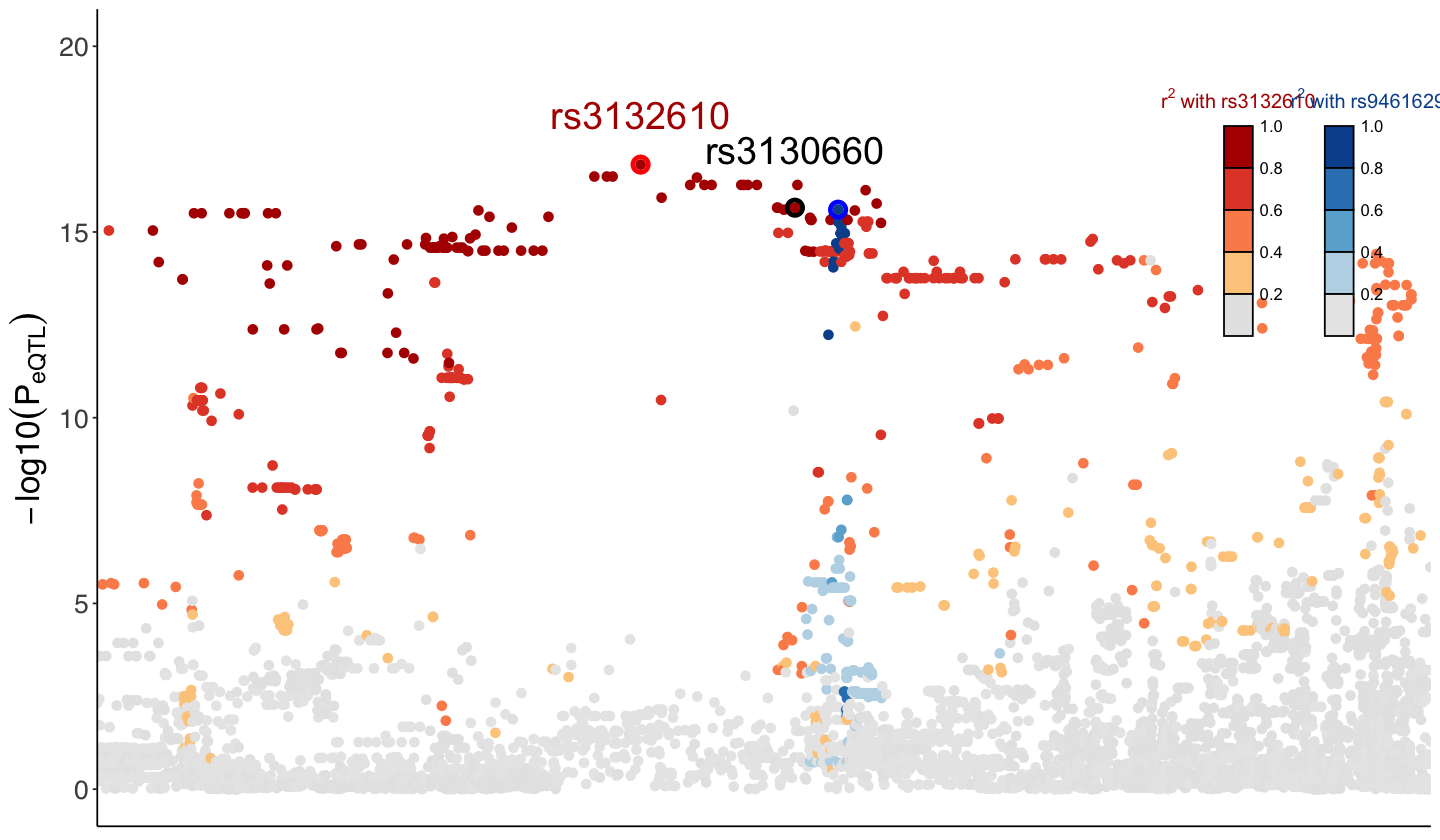

In [40]:
# adding legend box
legend_box = data.frame(x = 0.85, y = seq(0.8, 0.6, -0.05))

peQTL <- peQTL +   xlab("") + theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank())
peQTLlegend <- ggdraw(peQTL) +
            geom_rect(data = legend_box,
                      aes(xmin = x, xmax = x + 0.02, ymin = y, ymax = y + 0.05),
                      color = "black",
                      fill = rev(col1)) +
            draw_label("1.0", x = legend_box$x[1] + 0.02, y = 0.85, hjust = -0.3, size = 10) +
            draw_label("0.8", x = legend_box$x[1] + 0.02, y = legend_box$y[1], hjust = -0.3, size = 10) +
            draw_label("0.6", x = legend_box$x[2] + 0.02, y = legend_box$y[2], hjust = -0.3, size = 10) +
            draw_label("0.4", x = legend_box$x[3] + 0.02, y = legend_box$y[3], hjust = -0.3, size = 10) +
            draw_label("0.2", x = legend_box$x[4] + 0.02, y = legend_box$y[4], hjust = -0.3, size = 10) +
            draw_label(parse(text = "r^2~with~rs3132610"),color=col1[5], x = legend_box$x[1] + 0.01, y = legend_box$y[1], vjust = -3, size = 12)

legend_box2 = data.frame(x = .92, y = seq(0.8, 0.6, -0.05))

peQTLlegend <- ggdraw(peQTLlegend) +
            geom_rect(data = legend_box2,
                      aes(xmin = x, xmax = x + 0.02, ymin = y, ymax = y + 0.05),
                      color = "black",
                      fill = rev(col2)) +
            draw_label("1.0", x = legend_box2$x[1] + 0.02, y = 0.85, hjust = -0.3, size = 10) +
            draw_label("0.8", x = legend_box2$x[1] + 0.02, y = legend_box2$y[1], hjust = -0.3, size = 10) +
            draw_label("0.6", x = legend_box2$x[2] + 0.02, y = legend_box2$y[2], hjust = -0.3, size = 10) +
            draw_label("0.4", x = legend_box2$x[3] + 0.02, y = legend_box2$y[3], hjust = -0.3, size = 10) +
            draw_label("0.2", x = legend_box2$x[4] + 0.02, y = legend_box2$y[4], hjust = -0.3, size = 10) +
            draw_label(parse(text = "r^2~with~rs9461629"), color=col2[5],x = legend_box2$x[1] + 0.03, y = legend_box2$y[1], vjust = -3, size = 12)


options(repr.plot.width = 12, repr.plot.height = 7)

peQTLlegend
    

# gene track

In [48]:
#grch38
mart <- useMart(biomart='ENSEMBL_MART_ENSEMBL',
             dataset='hsapiens_gene_ensembl')
gbuild <- "grch38"
gtrack <- Gviz::GenomeAxisTrack(fontcolor="#000000", fontsize=16, margin = c(-3,-3),
                                ticksAt=c(30000000,31000000))

biomTrack <- Gviz::BiomartGeneRegionTrack(genome = gbuild,
                                            chromosome = 6,
                                            start = minpos,
                                            end = maxpos,
                                            filter = list("with_refseq_mrna"=TRUE),
                                            name = "ENSEMBL",
                                            background.panel="gray95",
                                            biomart = mart)

In [49]:
gtrack <- Gviz::GenomeAxisTrack( fontsize=14,lwd=1,
                               ticksAt=c(30000000,30100000,30300000,30500000, 
                                         30700000,30900000,31100000,31300000))                           

ht <- HighlightTrack(trackList = biomTrack,
                     start = pos, width = window,
                     chromosome = 6)

genetrack <- grid::grid.grabExpr(Gviz::plotTracks(list(biomTrack,gtrack),collapseTranscripts = "meta",transcriptAnnotation = "symbol",
        chromosome = 6,
        from = minpos,
        to= maxpos,
        showTitle = FALSE,
        labelPos = "alternating",
        distFromAxis = 5,
        innermargin = 0,
        background.panel="transparent",
        cex.font=20,cex.group=1,fontcolor.group="black",
        cex = 1.2))

# coloc analysis of g2g and *FLOT1* expression in GTEx tissues

In [42]:
coloc_all <- read.table("../data/coloc_results.txt",h=T,stringsAsFactors = F)
coloc_df <- coloc_all %>% filter(Gene=="FLOT1")

dim(coloc_df)

[1] 108   3

Warning message:
"Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2."


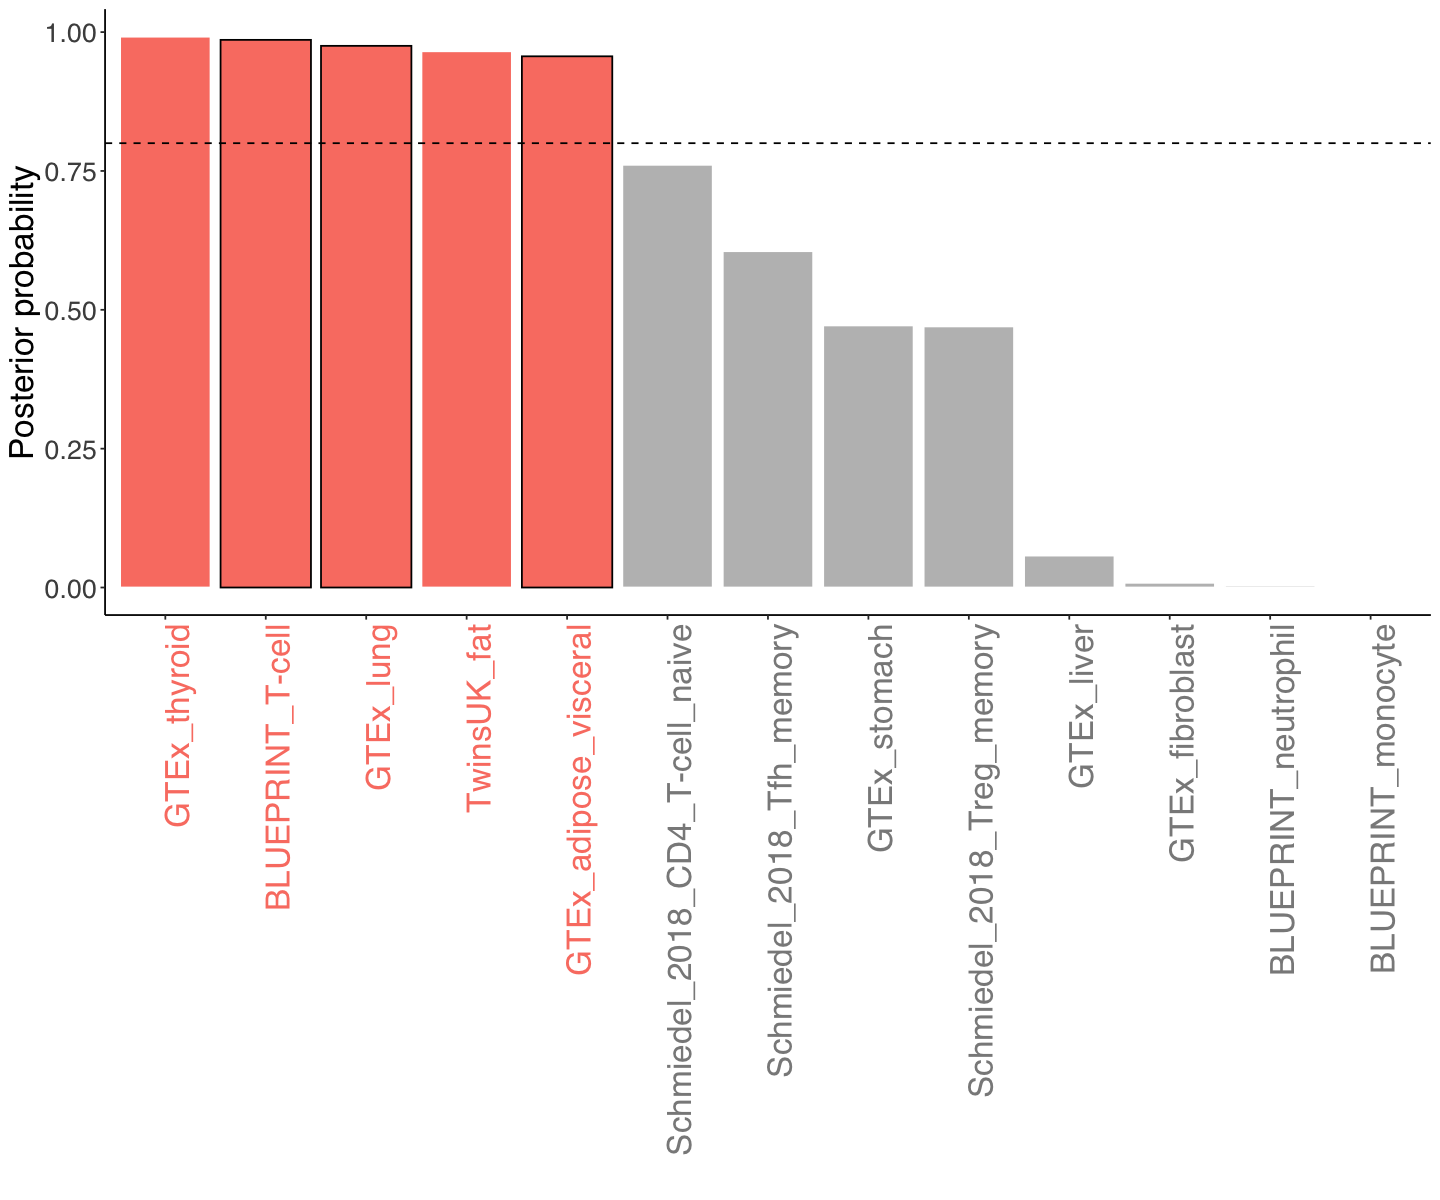

In [44]:
options(repr.plot.width = 12, repr.plot.height = 10)
highlight_tissues <- c("BLUEPRINT_T-cell","GTEx_lung","GTEx_adipose_visceral")

coloc_df$iscoloc <- ifelse(coloc_df$coloc_posterior > 0.8, "True", "False")
coloc_df$highlight <- ifelse(coloc_df$RNAseq_dataset %in% highlight_tissues, "True", "False")

# random select tissues for visualization
selected_tissues <- c("GTEx_thyroid","BLUEPRINT_T-cell","GTEx_adipose_visceral","GTEx_lung","TwinsUK_fat",
                     "Schmiedel_2018_Treg_memory","GTEx_stomach","Schmiedel_2018_Tfh_memory",
                      "Schmiedel_2018_CD4_T-cell_naive","Schmiedel_2018_Treg_memory",
                     "GTEx_liver","BLUEPRINT_monocyte","BLUEPRINT_neutrophil","GTEx_fibroblast","GTEx_fibroblast")

pbar <- ggplot(data=coloc_df %>% filter(RNAseq_dataset %in% selected_tissues), 
               aes(x=reorder(RNAseq_dataset, -coloc_posterior),y = coloc_posterior,
                                 fill = iscoloc, color=highlight)) + geom_bar(stat = "identity") 



pbar <-  pbar + scale_fill_manual(values = c("grey","salmon"),name="Posterior probability >0.8")


pbar <- pbar + scale_color_manual(values = c("white","black"),guide="none")


reorder_df <- coloc_df  %>% filter(RNAseq_dataset %in% selected_tissues) %>% arrange(-coloc_posterior)
text.col <- ifelse(reorder_df$iscoloc=="True","salmon","grey54")
#text.col <- ifelse(reorder_df$highlight=="True","black",text.col)
text.size <- ifelse(reorder_df$qtl_id %in% highlight_tissues,20,6)

pbar <- pbar + theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1,size=20,
                                                colour = text.col)) 
pbar <- pbar + geom_hline(yintercept=0.8, linetype="dashed", color = "black")


pbar <- pbar + ylab("Posterior probability") +
    xlab("")

pbar + theme(legend.position="none")


# combine figures

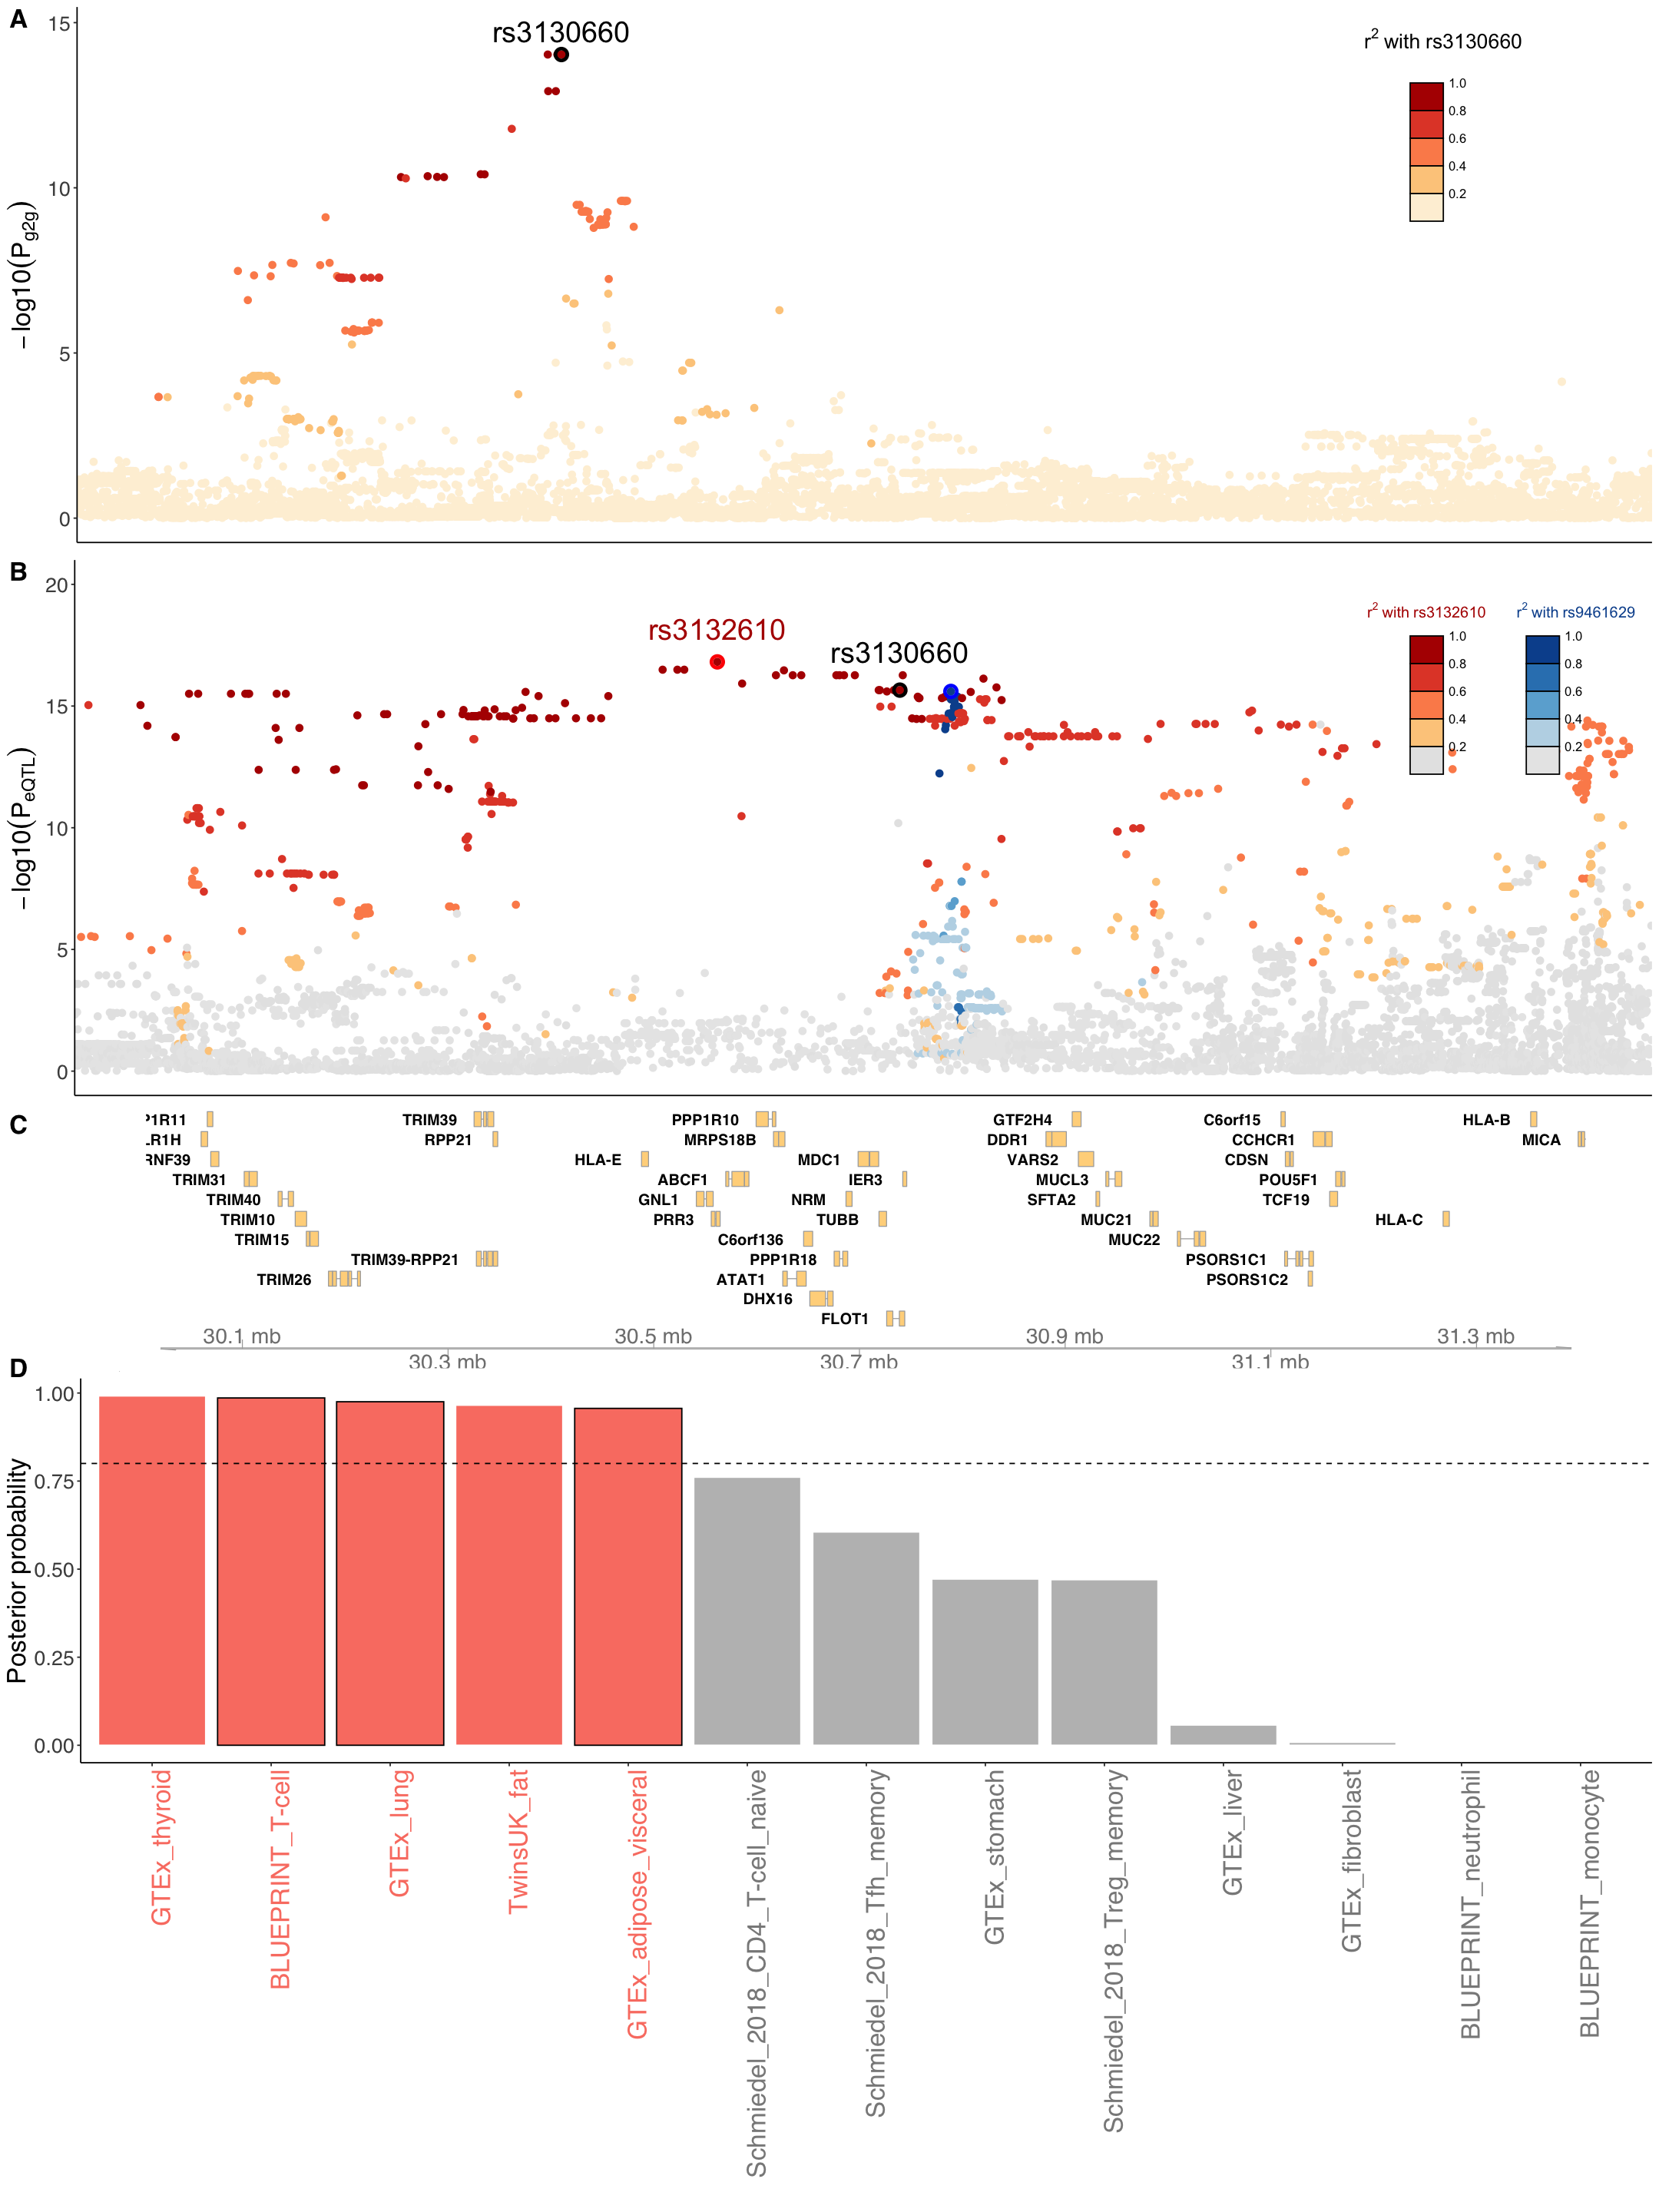

In [51]:
options(repr.plot.width = 18, repr.plot.height = 24)

ggdraw() +
  draw_plot(pGWAS, 
            x = 0, y = 0.75, width = 1, height = .25) +
    draw_plot(peQTLlegend , 
              x = 0, y = 0.5, width = 1, height = .25) +

    draw_plot(genetrack , x = 0.072, y=0.38,width=.9, height=0.12) +
  draw_plot(pbar + theme(legend.position="none"),#theme(legend.position="top",legend.justification="right"), 
            x = 0, y = 0, width = 1, height = .38) +
 # draw_plot(pp + theme(legend.position=c(0.35,0.81)), x = 0.7, y = 0.1, width = 0.3, height = .26) +
  draw_plot_label(label = c("A","B", "C", "D"), size = 20,font="bold",
                  x = c(0, 0,0 ,0), y = c(1, 0.75, .5, .39)) +
 theme(plot.background = element_rect(fill="white", color = NA))


In [52]:
ggsave("../figures/Fig3_flot1_summary.pdf",height=20,width=18)